In [1]:


import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
def load_data():
    """Charge et prépare les données"""
    df = pd.read_csv("../data/RAW_recipes.csv")
    
    # Extraire les valeurs nutritionnelles
    df['calories'] = df['nutrition'].apply(lambda x: eval(x)[0])
    df['total_fat'] = df['nutrition'].apply(lambda x: eval(x)[1])
    df['sugar'] = df['nutrition'].apply(lambda x: eval(x)[2])
    df['sodium'] = df['nutrition'].apply(lambda x: eval(x)[3])
    df['protein'] = df['nutrition'].apply(lambda x: eval(x)[4])
    df['saturated_fat'] = df['nutrition'].apply(lambda x: eval(x)[5])
    df['carbohydrates'] = df['nutrition'].apply(lambda x: eval(x)[6])
    
    return df

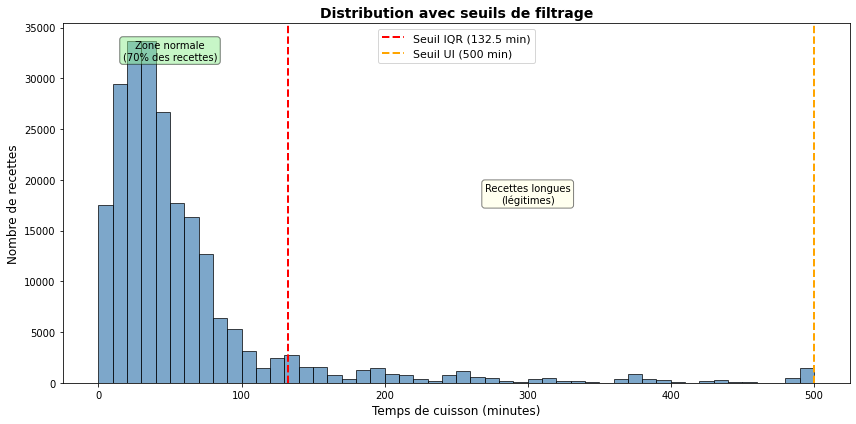

In [9]:
#distribution_avec_seuils
df = load_data()

fig, ax = plt.subplots(figsize=(12, 6))

# Filtrer pour la visualisation
df_filtered = df[df['minutes'] <= 500]

ax.hist(df_filtered['minutes'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(132.5, color='red', linestyle='--', linewidth=2, label='Seuil IQR (132.5 min)')
ax.axvline(500, color='orange', linestyle='--', linewidth=2, label='Seuil UI (500 min)')
ax.set_xlabel('Temps de cuisson (minutes)', fontsize=12)
ax.set_ylabel('Nombre de recettes', fontsize=12)
ax.set_title('Distribution avec seuils de filtrage', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

# Annoter les zones
ax.text(50, ax.get_ylim()[1]*0.9, 'Zone normale\n(70% des recettes)', 
        fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.text(300, ax.get_ylim()[1]*0.5, 'Recettes longues\n(légitimes)', 
        fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

In [3]:

def calculate_statistics(df, column):
    """Calcule skewness, kurtosis et outliers pour une variable"""
    
    print(f"\n{'='*60}")
    print(f"ANALYSE DE: {column.upper()}")
    print(f"{'='*60}")
    
    # Statistiques descriptives
    print(f"\n Statistiques descriptives:")
    print(f"  Moyenne:    {df[column].mean():.2f}")
    print(f"  Médiane:    {df[column].median():.2f}")
    print(f"  Écart-type: {df[column].std():.2f}")
    print(f"  Min:        {df[column].min():.2f}")
    print(f"  Max:        {df[column].max():.2f}")
    
    # Skewness
    skewness = skew(df[column].dropna())
    print(f"\n Skewness: {skewness:.3f}")
    if abs(skewness) < 0.5:
        print("  → Distribution relativement symétrique")
    elif skewness > 0.5:
        print("  → Distribution asymétrique à droite (queue longue)")
    else:
        print("  → Distribution asymétrique à gauche")
    
    # Kurtosis
    kurt = kurtosis(df[column].dropna())
    print(f"\n Kurtosis: {kurt:.3f}")
    if kurt > 3:
        print("  → Queues épaisses (nombreux outliers)")
    elif kurt < -1:
        print("  → Queues fines (peu d'outliers)")
    else:
        print("  → Distribution proche de la normale")
    
    # Outliers (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_pct = len(outliers) / len(df) * 100
    
    print(f"\n Valeurs aberrantes (méthode IQR):")
    print(f"  Q1:           {Q1:.2f}")
    print(f"  Q3:           {Q3:.2f}")
    print(f"  IQR:          {IQR:.2f}")
    print(f"  Limites:      [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers:     {len(outliers):,} ({outlier_pct:.2f}%)")
    
    if outlier_pct > 10:
        print("ATTENTION: Plus de 10% de valeurs aberrantes!")
    
    return {
        'mean': df[column].mean(),
        'median': df[column].median(),
        'std': df[column].std(),
        'min': df[column].min(),
        'max': df[column].max(),
        'skewness': skewness,
        'kurtosis': kurt,
        'outliers_count': len(outliers),
        'outliers_pct': outlier_pct,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }

In [4]:
def plot_all_distributions(df, columns):
    """Crée un graphique complet pour toutes les variables"""
    
    n_cols = len(columns)
    fig, axes = plt.subplots(n_cols, 3, figsize=(18, 5*n_cols))
    
    for idx, col in enumerate(columns):
        # Histogramme
        axes[idx, 0].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx, 0].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
        axes[idx, 0].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label='Médiane')
        axes[idx, 0].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel(col)
        axes[idx, 0].set_ylabel('Fréquence')
        axes[idx, 0].legend()
        
        # Boxplot
        axes[idx, 1].boxplot(df[col].dropna(), vert=True)
        axes[idx, 1].set_title(f'Boxplot de {col}', fontsize=12, fontweight='bold')
        axes[idx, 1].set_ylabel(col)
        axes[idx, 1].grid(axis='y', alpha=0.3)
        
        # Histogramme zoomé (sans outliers extrêmes)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 3 * IQR  # Zoom sur 99% des données
        
        df_zoom = df[df[col] <= upper_limit]
        axes[idx, 2].hist(df_zoom[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
        axes[idx, 2].set_title(f'Distribution de {col} (zoom)', fontsize=12, fontweight='bold')
        axes[idx, 2].set_xlabel(col)
        axes[idx, 2].set_ylabel('Fréquence')
        axes[idx, 2].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label='Médiane')
        axes[idx, 2].legend()
    
    plt.tight_layout()
   
    plt.show()

In [5]:
def create_summary_table(results):
    """Crée un tableau récapitulatif comparatif"""
    
    print(f"\n{'='*80}")
    print(" TABLEAU RÉCAPITULATIF COMPARATIF")
    print(f"{'='*80}\n")
    
    summary_df = pd.DataFrame(results).T
    
    # Formater pour l'affichage
    summary_df['mean'] = summary_df['mean'].apply(lambda x: f"{x:.2f}")
    summary_df['median'] = summary_df['median'].apply(lambda x: f"{x:.2f}")
    summary_df['skewness'] = summary_df['skewness'].apply(lambda x: f"{x:.2f}")
    summary_df['kurtosis'] = summary_df['kurtosis'].apply(lambda x: f"{x:.2f}")
    summary_df['outliers_pct'] = summary_df['outliers_pct'].apply(lambda x: f"{x:.2f}%")
    
    # Afficher
    print(summary_df[['mean', 'median', 'skewness', 'kurtosis', 'outliers_pct']].to_string())

 Chargement des données...
231,637 recettes chargées


ANALYSE DE: MINUTES

 Statistiques descriptives:
  Moyenne:    9398.55
  Médiane:    40.00
  Écart-type: 4461963.04
  Min:        0.00
  Max:        2147483647.00

 Skewness: 481.283
  → Distribution asymétrique à droite (queue longue)

 Kurtosis: 231631.798
  → Queues épaisses (nombreux outliers)

 Valeurs aberrantes (méthode IQR):
  Q1:           20.00
  Q3:           65.00
  IQR:          45.00
  Limites:      [-47.50, 132.50]
  Outliers:     23,714 (10.24%)
ATTENTION: Plus de 10% de valeurs aberrantes!

ANALYSE DE: N_INGREDIENTS

 Statistiques descriptives:
  Moyenne:    9.05
  Médiane:    9.00
  Écart-type: 3.73
  Min:        1.00
  Max:        43.00

 Skewness: 0.768
  → Distribution asymétrique à droite (queue longue)

 Kurtosis: 1.176
  → Distribution proche de la normale

 Valeurs aberrantes (méthode IQR):
  Q1:           6.00
  Q3:           11.00
  IQR:          5.00
  Limites:      [-1.50, 18.50]
  Outliers:     3,770 (

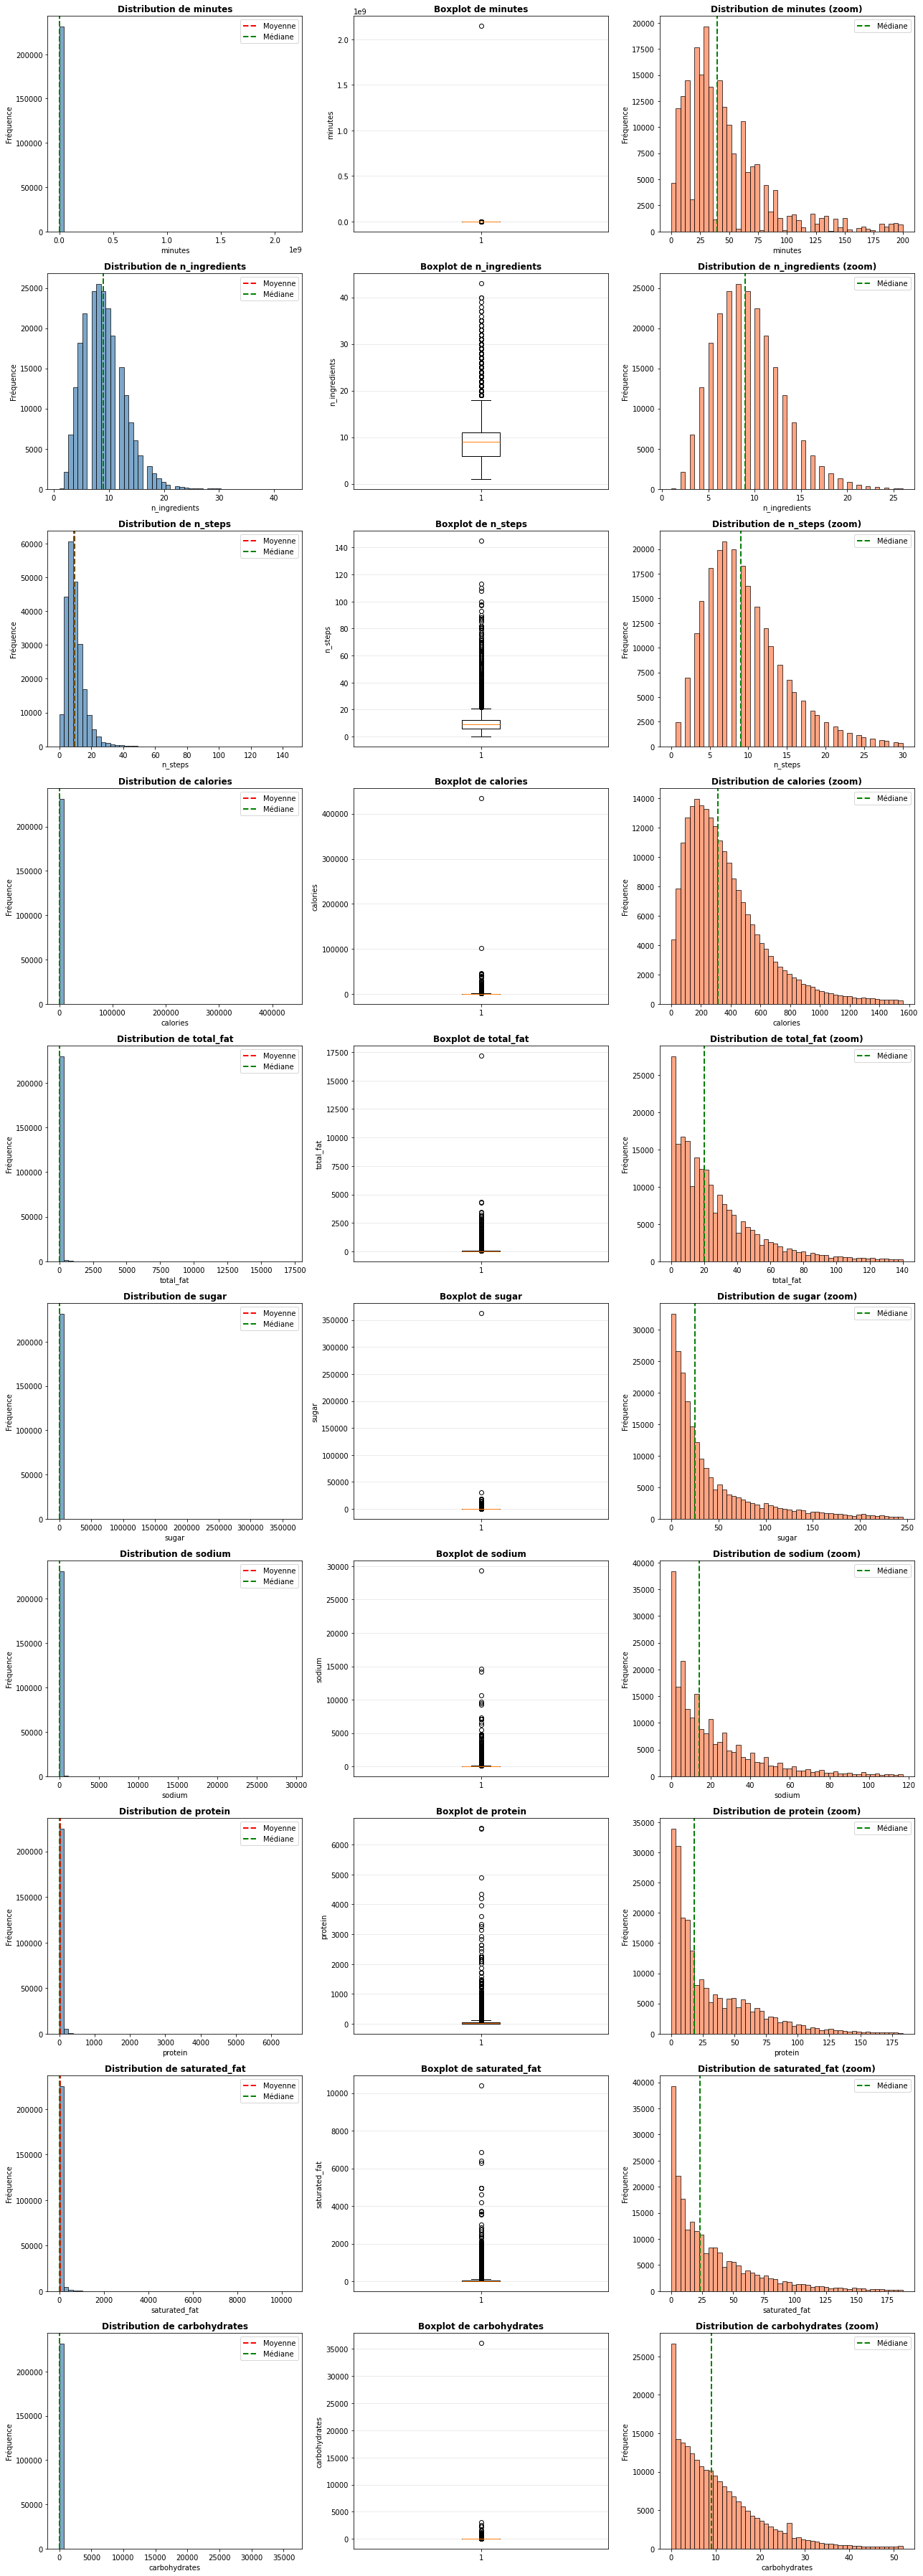

In [7]:
def main():
    """Fonction principale"""
    
    print(" Chargement des données...")
    df = load_data()
    print(f"{len(df):,} recettes chargées\n")
    
    # Variables à analyser
    columns_to_analyze = [
        'minutes',
        'n_ingredients',
        'n_steps',
        'calories',
        'total_fat',
        'sugar',
        'sodium',
        'protein',
        'saturated_fat',
        'carbohydrates'
    ]
    
    # Calculer les statistiques pour chaque variable
    results = {}
    for col in columns_to_analyze:
        results[col] = calculate_statistics(df, col)
    
    # Créer le tableau récapitulatif
    create_summary_table(results)
    
    # Générer les graphiques
    print("\n Génération des graphiques complets...")
    plot_all_distributions(df, columns_to_analyze)
    

if __name__ == "__main__":
    main()